DR Guia passo a passo para construir um modelo de rede neural profunda com Keras para prever Preços do Airbnb em Nova York e implantação como API REST usando Flask

Este guia permitirá implantar um modelo de aprendizado de máquina começando do zero. Aqui estão as etapas você vai cobrir:

- Defina seu objetivo
- Carregar dados
- Exploração de dados
- Preparação de dados
- Construa e avalie seu modelo
- Salve o modelo
- Construir API REST
- Implantar em produção

### Definir objetivo/meta

Obviamente, você precisa saber por que precisa de um modelo de aprendizado de máquina (ML).Conhecer o objetivo fornece insights sobre:

- O ML é a abordagem certa?
- De quais dados eu preciso?
- Qual será a aparência de um “bom modelo”? Quais métricas posso usar?
- Como resolvo o problema agora? Quão precisa é a solução?
- Quanto custará manter este modelo em funcionamento?

Em nosso exemplo, estamos tentando prever o preço de listagem do Airbnb³² por noite em Nova York. Nosso objetivo é claro - dados alguns dados, queremos que nosso modelo preveja quanto custará alugar um determinado imóvel
por noite.

### Carregar dados

Os dados vêm do Airbnb Open Data e estão hospedados no Kaggle³³

Desde 2008, hóspedes e anfitriões usam o Airbnb para ampliar as possibilidades de viagem e apresentar uma maneira mais única e personalizada de experimentar o mundo. Este conjunto de dados descreve
a atividade de listagem e métricas em NYC, NY para 2019.

#### Configuração 

Começaremos com várias importações e definindo uma semente aleatória para reprodutibilidade:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [14]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [15]:
df = pd.read_csv('airbnb_data\AB_NYC_2019.csv')

In [16]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


Como podemos entender do que se tratam nossos dados?

### Data exploration

Esta etapa é crucial. O objetivo é obter uma melhor compreensão dos dados. Você pode ficar tentado
para impulsionar o processo de modelagem, mas isso seria abaixo do ideal. Olhando para grandes quantidades de
Por exemplo, procurar padrões e visualizar distribuições construirá sua intuição sobre os dados.
Essa intuição será útil ao modelar, imputar dados ausentes e observar valores discrepantes.
Uma maneira fácil de começar é contar o número de linhas e colunas em seu conjunto de dados:

In [17]:
df.shape

(48895, 16)

Temos 48.895 linhas e 16 colunas. Dados suficientes para fazer algo interessante. Vamos começar com a variável que estamos tentando prever o preço. Para traçar a distribuição, usaremos

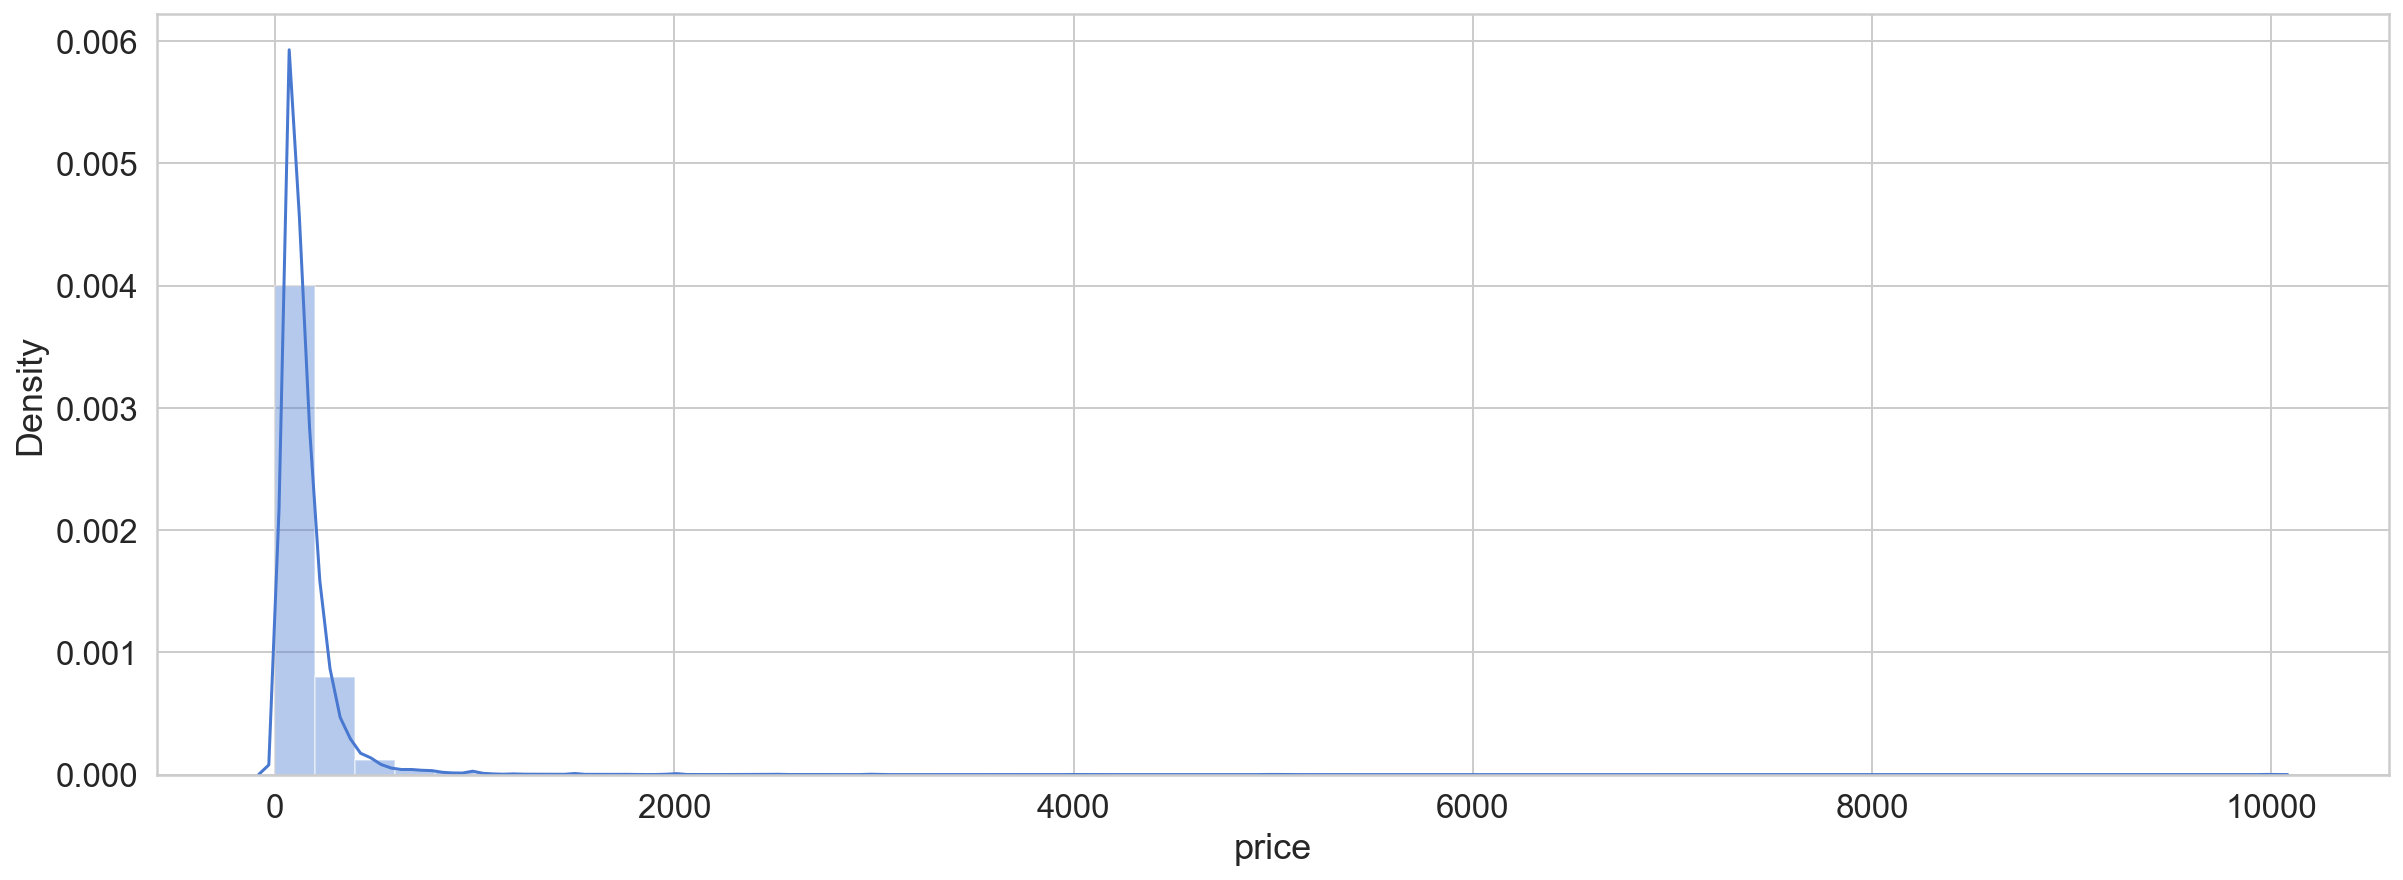

In [18]:
sns.distplot(df.price);

Temos uma distribuição altamente distorcida com alguns valores na faixa de 10.000 (você pode querer explore-os). Usaremos um truque - transformação de log:

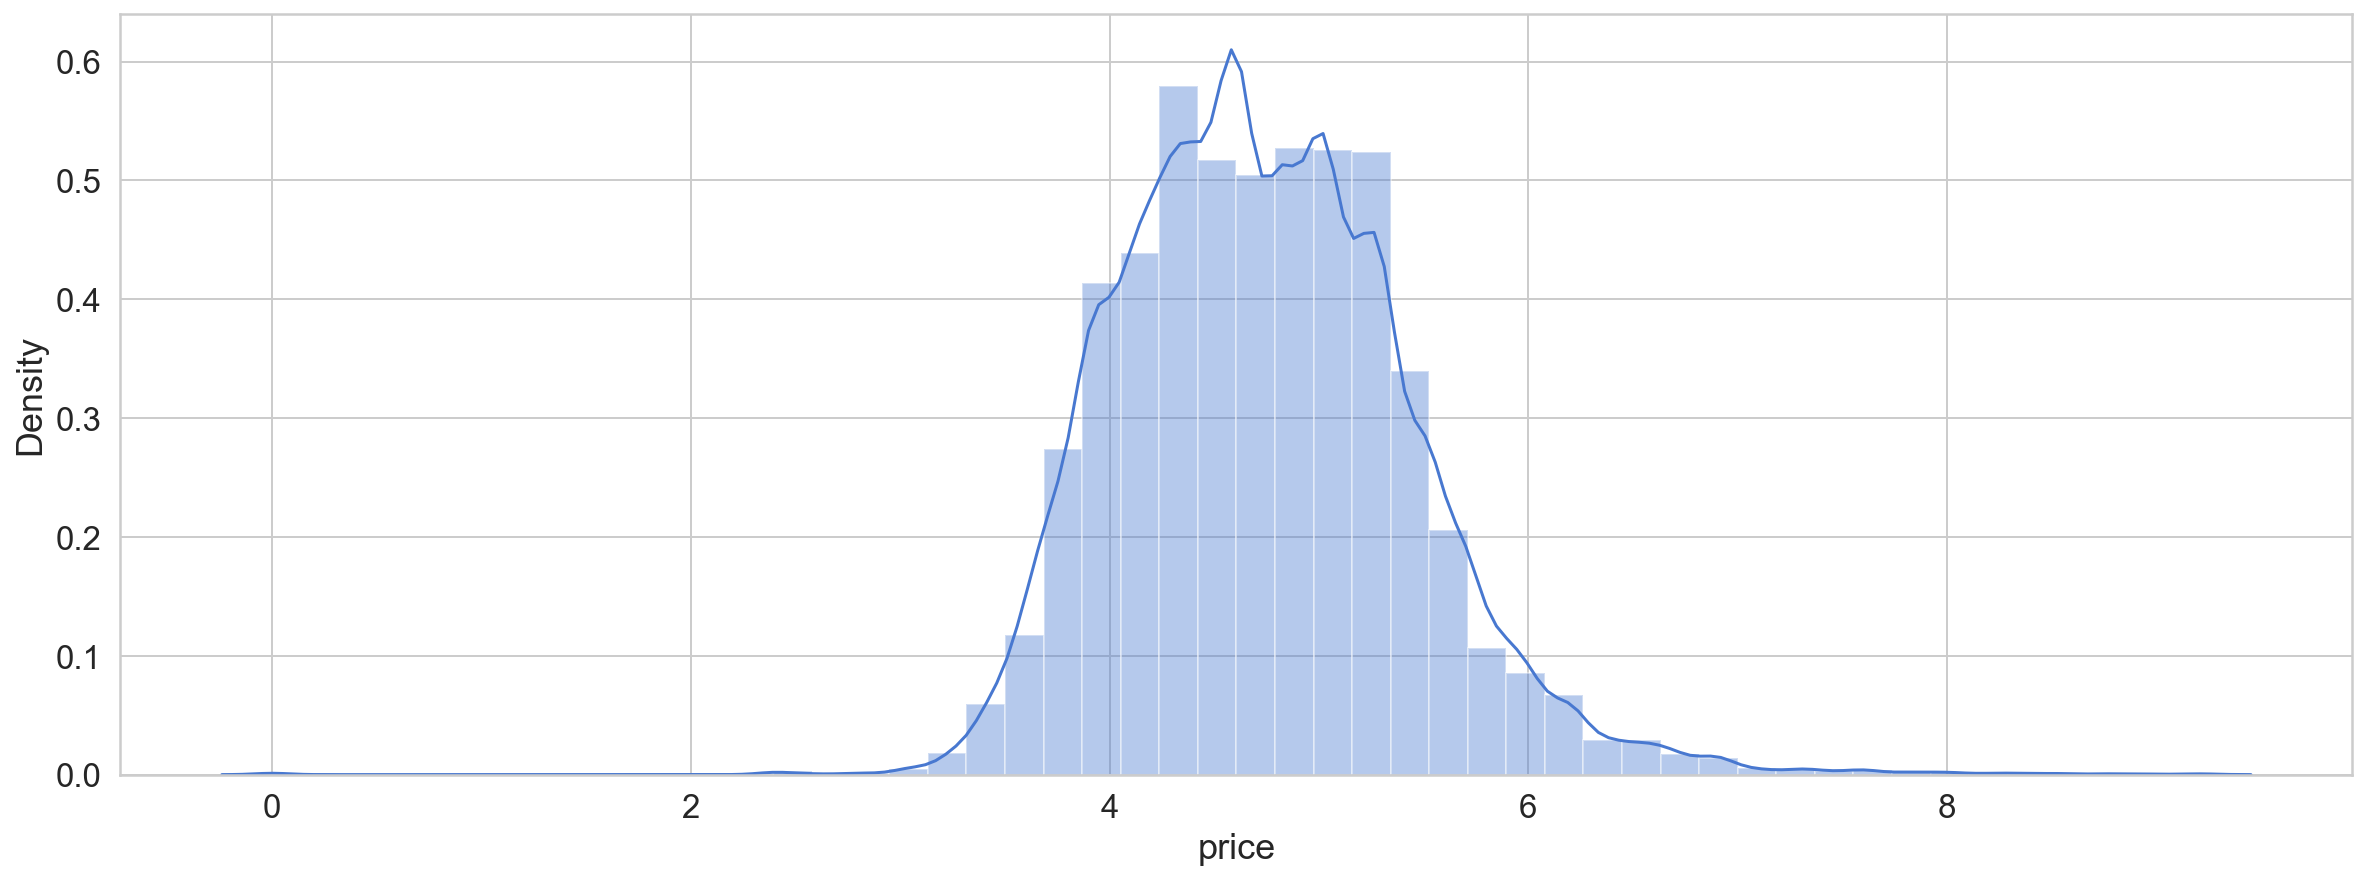

In [19]:
sns.distplot(np.log1p(df.price));

Isso se parece mais com uma distribuição normal. Acontece que isso pode ajudar seu modelo a aprender melhor o dados³⁴. Você terá que se lembrar de pré-processar os dados antes de treinar e prever. O tipo de quarto parece ser outro ponto interessante. Vamos dar uma olhada:

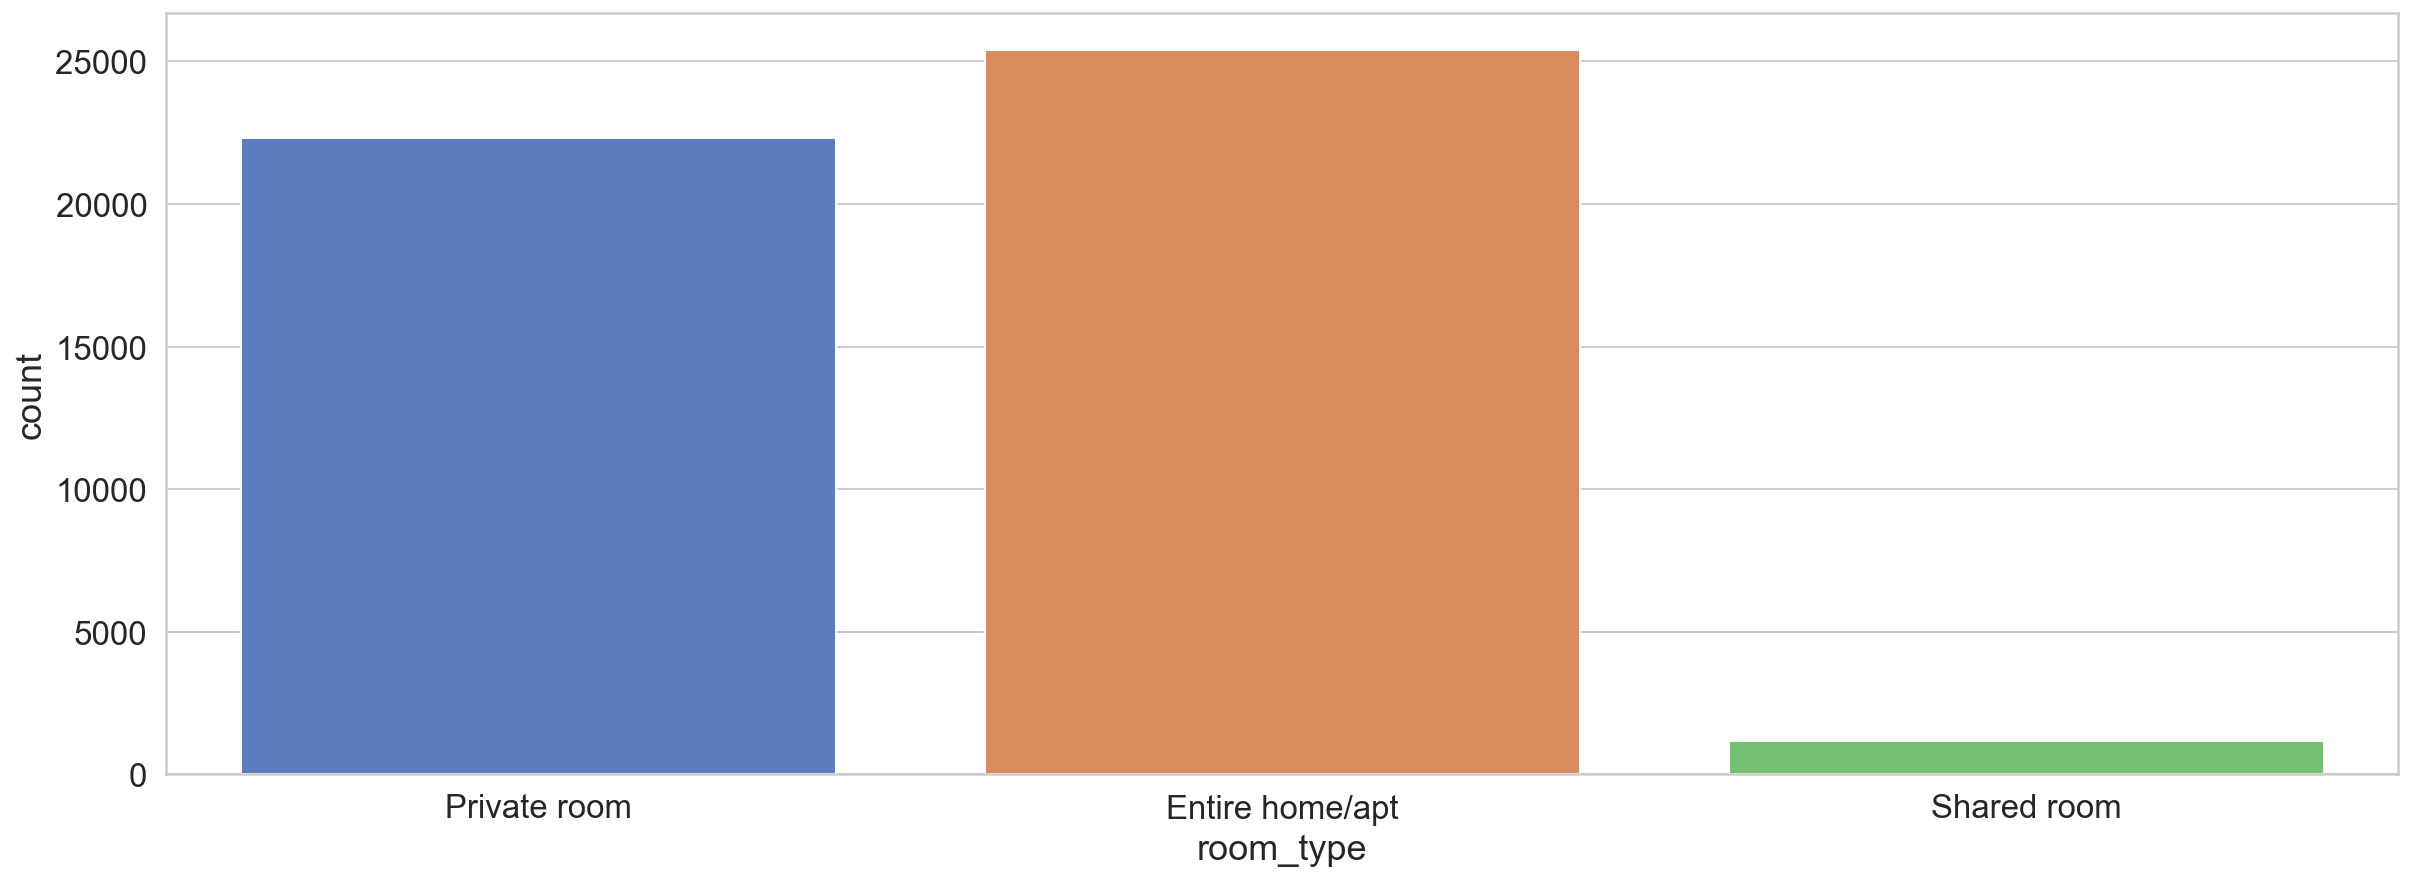

In [20]:
sns.countplot(x='room_type', data=df);

A maioria das listagens oferece lugares inteiros ou quartos privados. E quanto à localização? Que bairro grupos estão mais representados?

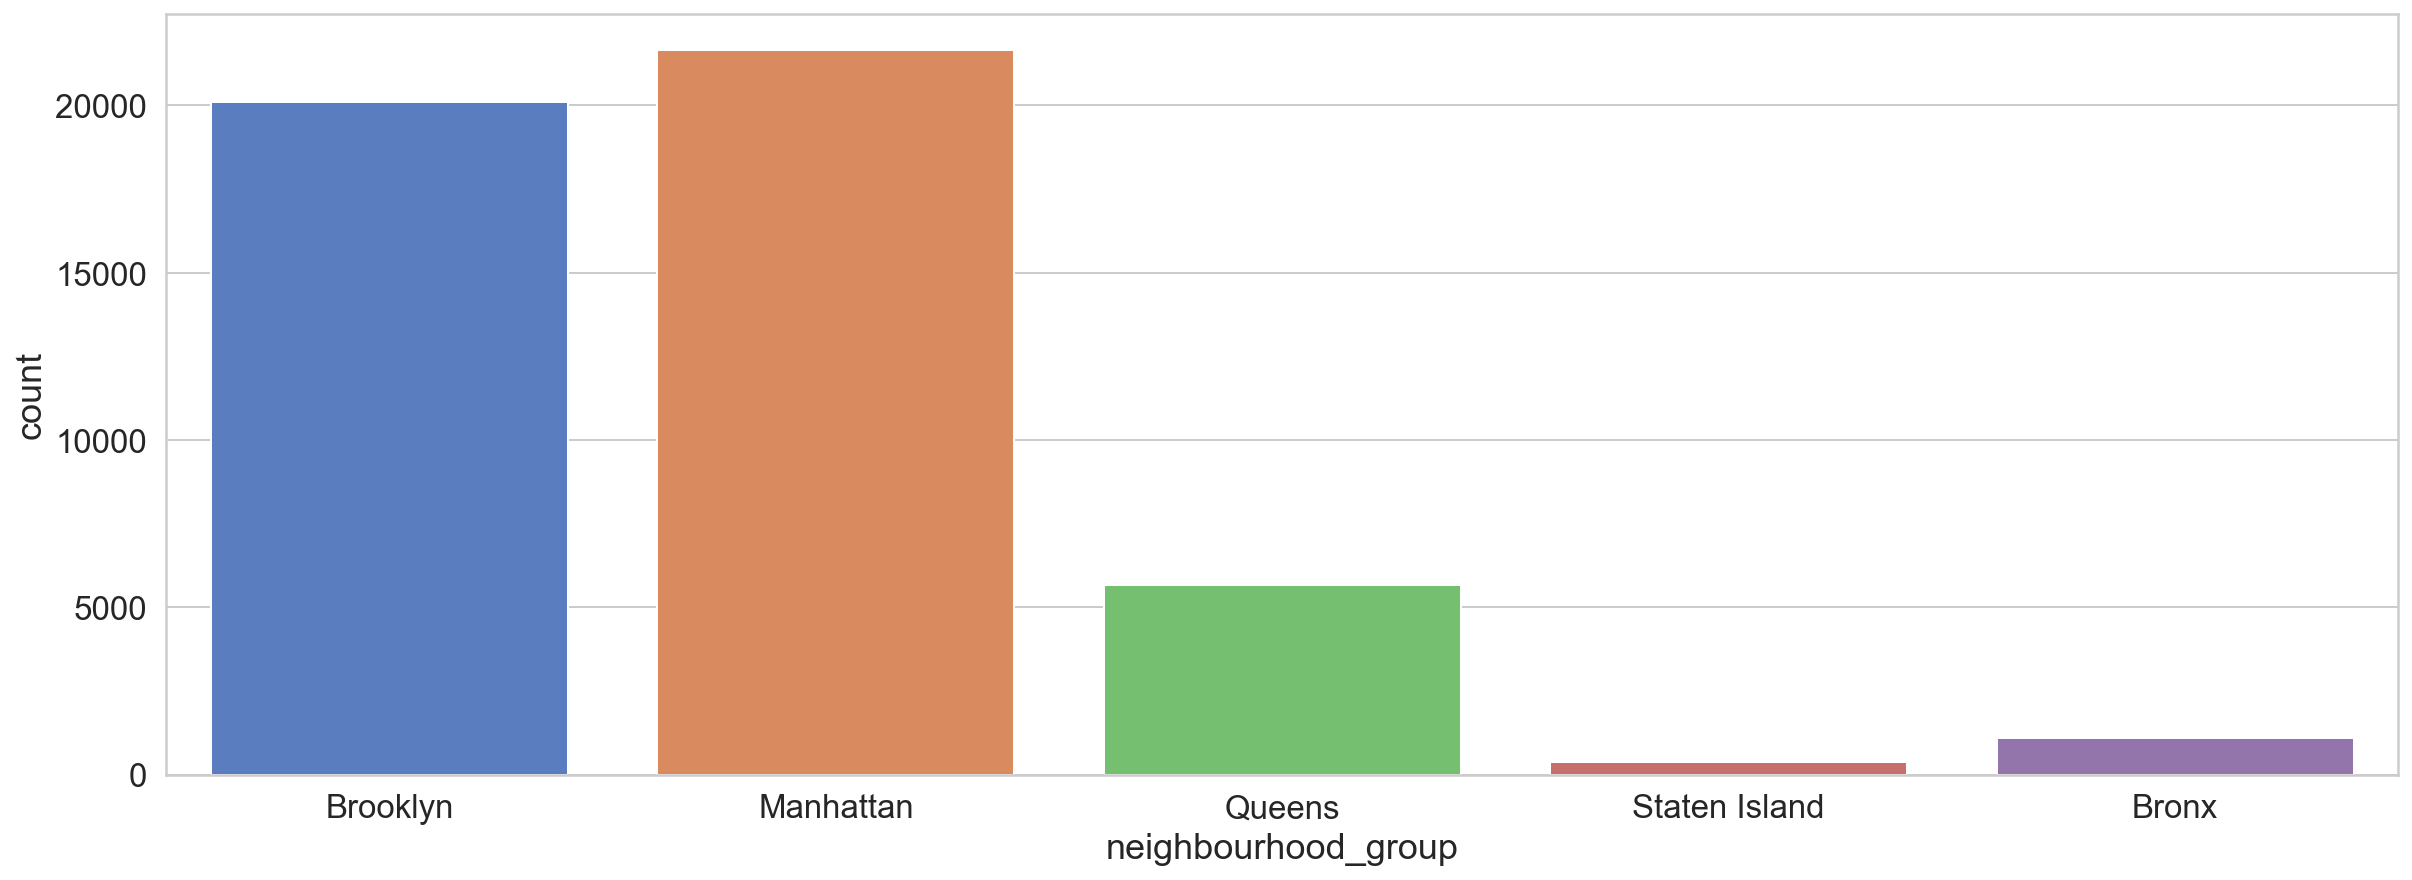

In [21]:
sns.countplot(x='neighbourhood_group', data=df);

Como esperado, Manhattan lidera. Obviamente, o Brooklyn também está muito bem representado. Você pode
obrigado Mos Def, Nas, Masta Ace e Fabolous por isso.
Outra característica interessante é o número de avaliações. Vamos dar uma olhada nisso:

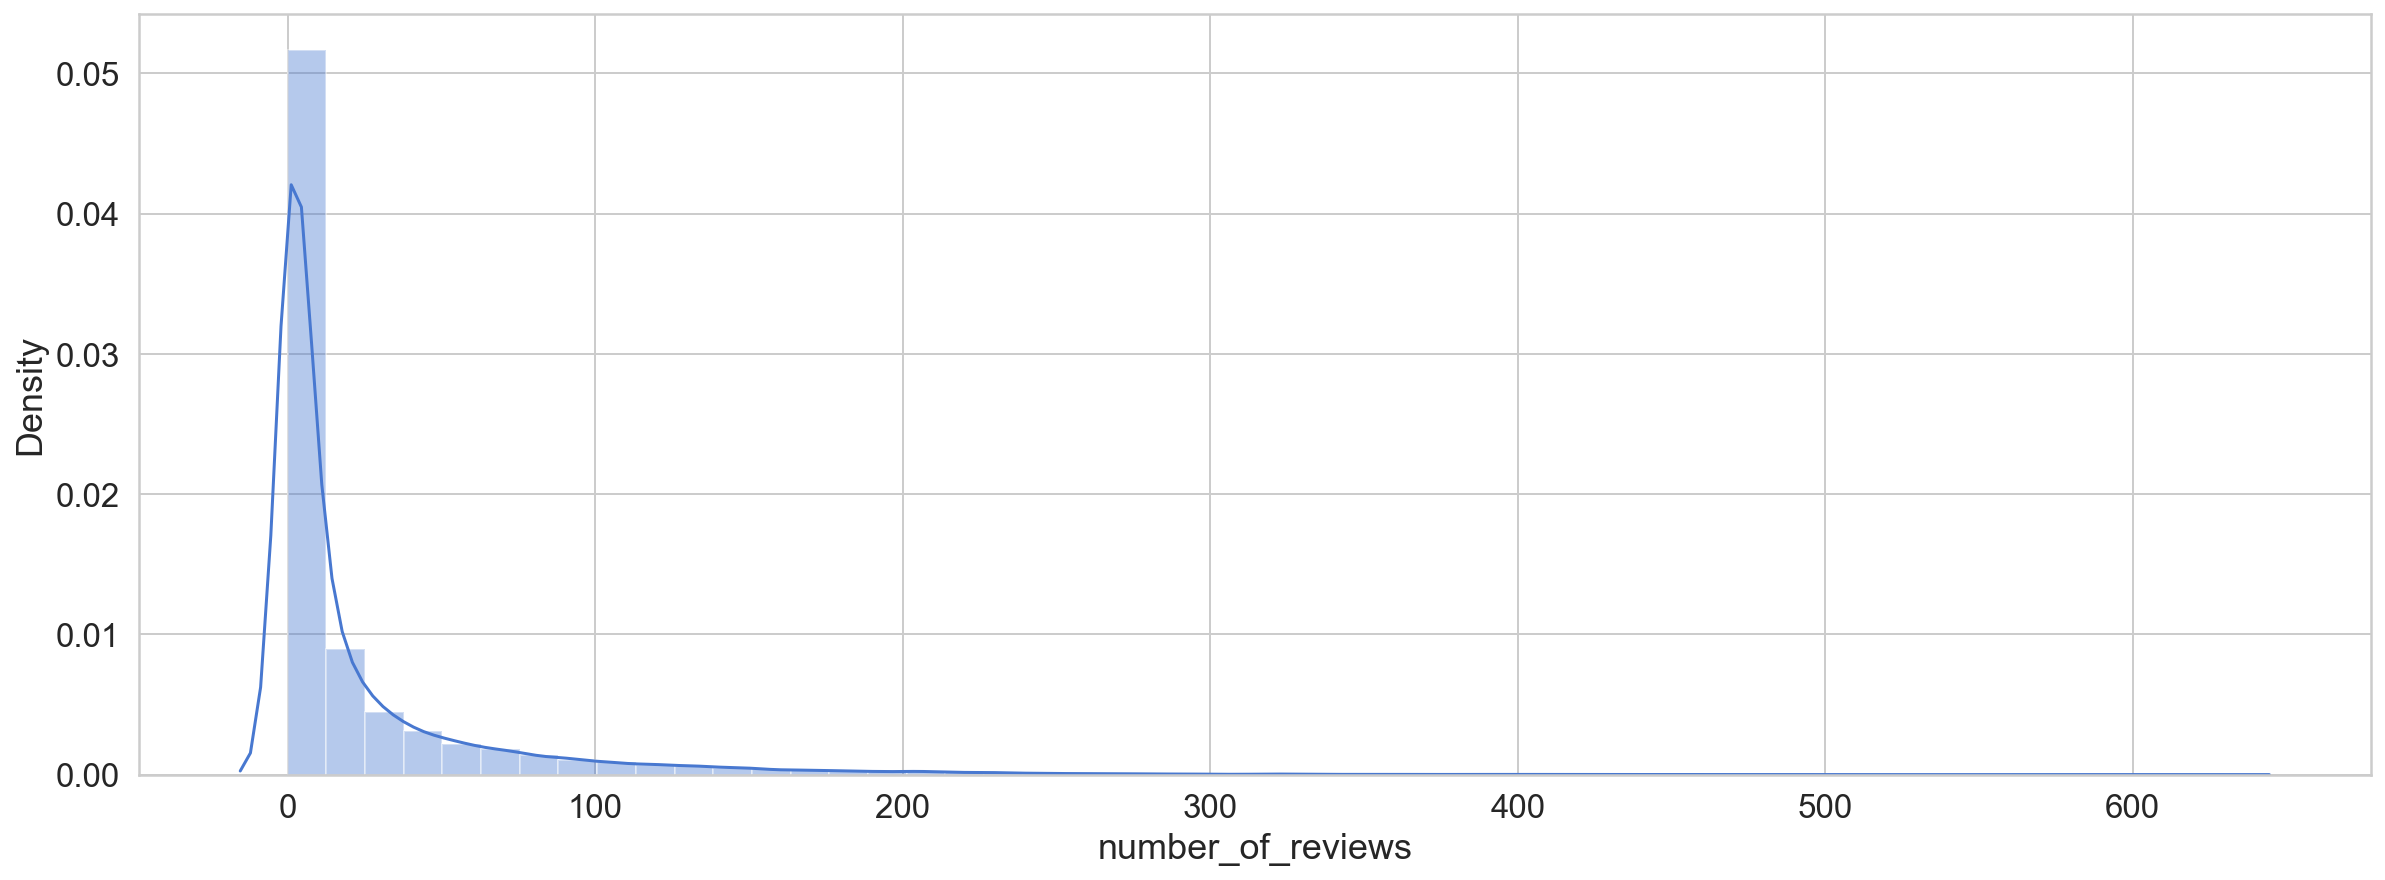

In [22]:
sns.distplot(df.number_of_reviews);

Este parece seguir uma lei de potência³⁵ (tem cauda gorda). Este parece seguir uma lei de potência³⁶ (é tem uma cauda gorda). Parece haver alguns valores discrepantes (à direita) que podem ser de interesse para investigação.

#### Encontrando Correlações

A análise de correlação pode fornecer dicas sobre quais recursos podem ter poder preditivo quando treinando seu modelo.

Lembre-se, correlação não implica causalidade³⁷

Calcular o coeficiente de correlação de Pearson³⁸ entre um par de recursos é fácil:

In [23]:
corr_matrix = df.corr();

Vejamos a correlação do preço com os demais atributos:

In [24]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

O coeficiente de correlação é definido no intervalo de -1 a 1. Um valor próximo de 0 significa que não há correlação. O valor 1 sugere uma correlação positiva perfeita (por exemplo, à medida que o preço do Bitcoin aumenta, seus sonhos de possuir mais também estão aumentando!). O valor de -1 sugere correlação negativa perfeita (por exemplo, um grande número de críticas negativas deve estar correlacionado com preços mais baixos).

A correlação em nosso conjunto de dados parece muito ruim. Felizmente, os recursos categóricos não estão incluídos aqui. Eles também podem ter algum poder preditivo! Como podemos usá-los?

### Prepare os dados

O objetivo aqui é transformar os dados em um formato adequado ao seu modelo. Existem vários coisas que você deseja fazer ao lidar com dados estruturados (pense em CSV, banco de dados):

- Lidar com dados ausentes
- Remova colunas desnecessárias
- Transformar quaisquer recursos categóricos em números/vetores
- Dimensionar recursos numéricos